In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#### Combine predictions into 1 file

In [12]:
df_ensemble = pd.read_csv('ace_gcode_twomodels_data.csv')
df_ensemble.head()

,Unnamed: 0,class,pred_1,prob_1,pred_2,prob_2
0,8569,LAB RESULTS,LAB RESULTS,0.754411,LAB RESULTS,0.983233
1,4669,QUERY ON CURRENT APPOINTMENT,MEDICATION RELATED,0.356858,MEDICATION RELATED,0.757207
2,3916,NEW APPOINTMENT,NEW APPOINTMENT,0.824907,NEW APPOINTMENT,0.763332
3,2586,MEDICATION RELATED,NEW APPOINTMENT,0.881867,NEW APPOINTMENT,0.753146
4,2149,QUERIES FROM PHARMACY,REFILL,0.847968,MEDICATION RELATED,0.454662


#### Threshold Report

In [7]:
# create a threshold report
range = np.arange(0, 1.0, 0.05).tolist()
range.sort(reverse=True)
df_scores = pd.DataFrame(range, columns=['confidence'])
df_scores.head()

# find the threshold 
def threshold_error(data, pred, prob, value):
    df_temp = data[data[prob] > value]
    accuracy = round(accuracy_score(df_temp['class'], df_temp[pred]) * 100, 2)
    error_rate = 100 - accuracy
    return error_rate

def threshold_percent(data, prob, value):
    count_overall = data.shape[0]
    df_temp = data[data[prob] > value]
    count_threshold = df_temp.shape[0]
    percent = round((count_threshold / count_overall) * 100, 2)
    return percent

df_scores['model_1_error'] =  df_scores.apply(lambda row: threshold_error(df_ensemble, 'pred_1', 'prob_1', row['confidence']), axis=1)
df_scores['model_1_rate'] =  df_scores.apply(lambda row: threshold_percent(df_ensemble, 'prob_1', row['confidence']), axis=1)

df_scores['model_2_error'] =  df_scores.apply(lambda row: threshold_error(df_ensemble, 'pred_2', 'prob_2', row['confidence']), axis=1)
df_scores['model_2_rate'] =  df_scores.apply(lambda row: threshold_percent(df_ensemble, 'prob_2', row['confidence']), axis=1)

df_scores = df_scores.replace(np.nan,0)
df_scores.head(5)

,confidence,model_1_error,model_1_rate,model_2_error,model_2_rate
0,0.95,11.59,13.8,8.72,14.9
1,0.90,9.73,18.5,12.55,23.1
2,0.85,16.24,23.4,15.38,29.9
3,0.80,20.65,27.6,18.75,36.8
4,0.75,23.73,31.6,21.11,43.1


#### Graphical Comparison by Threshold

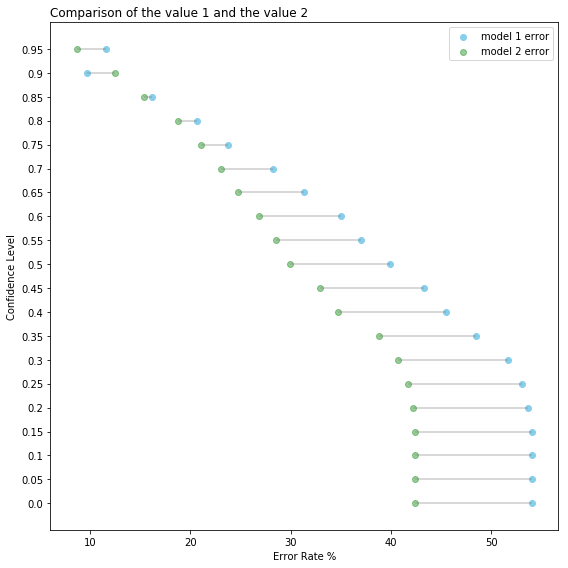

In [11]:
import matplotlib.pylab as plt
import seaborn as sns


# Reorder it following the values of the first value:
#del range

df_sorted = df_scores.sort_values(by='confidence')
my_range=range(1,len(df_scores.confidence)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=df_sorted['model_1_error'], xmax=df_sorted['model_2_error'], color='grey', alpha=0.4)
plt.scatter(df_sorted['model_1_error'], my_range, color='skyblue', alpha=1, label='model 1 error')
plt.scatter(df_sorted['model_2_error'], my_range, color='green', alpha=0.4 , label='model 2 error')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, round(df_sorted['confidence'],2))
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Error Rate %')
plt.ylabel('Confidence Level')

# save the figure to folder
plt.tight_layout()
#plt.rcParams["figure.figsize"] = (20, 10)
#plt.savefig(r"compare_alldata_iterativetraining.png")

It looks like Model 2 is better at predicting records above 95% confidence, therefore we will use ACE process 2 and send all records below 95% confidence to be predicted by Model 1.

# ACE

1. ACE process 1: Two models agree = output
2. ACE process 2: Model 2 using a threshold, then send to Model 1 for all other predictions


#### Process 1

In [16]:
df_process_1 = df_ensemble[df_ensemble['pred_1'] == df_ensemble['pred_2']]

In [17]:
def threshold_percent_agree(data_all, data, prob, value):
    count_overall = data_all.shape[0]
    df_temp = data[data[prob] > value]
    count_threshold = df_temp.shape[0]
    percent = round((count_threshold / count_overall) * 100, 2)
    return percent
df_scores['ace1_error'] =  df_scores.apply(lambda row: threshold_error(df_process_1, 'pred_2', 'prob_2', row['confidence']), axis=1)
df_scores['ace1_rate'] =  df_scores.apply(lambda row: threshold_percent_agree(df_ensemble, df_process_1, 'prob_1', row['confidence']), axis=1)

df_scores = df_scores.replace(np.nan,0)
df_scores.head(10)

,confidence,model_1_error,model_1_rate,model_2_error,model_2_rate,ace1_error,ace1_rate
0,0.95,11.59,13.8,8.72,14.9,6.35,13.5
1,0.90,9.73,18.5,12.55,23.1,9.42,17.9
2,0.85,16.24,23.4,15.38,29.9,13.19,22.0
3,0.80,20.65,27.6,18.75,36.8,14.89,24.9
4,0.75,23.73,31.6,21.11,43.1,17.34,27.8
5,0.70,28.25,36.1,23.06,47.7,18.29,29.9
6,0.65,31.35,42.1,24.71,51.8,19.68,33.7
7,0.60,34.97,46.9,26.86,56.6,20.40,36.4
8,0.55,37.04,52.1,28.55,60.6,21.26,39.4
9,0.50,39.93,57.6,29.89,64.9,22.53,42.0


#### Process 2: Model 1 threshold, sent to Model 2

In [160]:
threshold_selected = 0.95

df_process_2 = df_ensemble.copy()

def threshold_probs(threshold, prob_a, prob_b):
    if prob_a > threshold:
        return prob_a
    else: 
        return prob_b

def threshold_preds(threshold, prob_a, pred_a, pred_b):
    if prob_a > threshold:
        return pred_a
    else: 
        return pred_b    

# Apply function on column
df_process_2['ace2_prob'] = df_process_2.apply(lambda row: threshold_probs(threshold_selected,row['prob_2'],row['prob_1']), axis=1)
df_process_2['ace2_pred'] = df_process_2.apply(lambda row: threshold_preds(threshold_selected,row['prob_2'],row['pred_2'],row['pred_1']), axis=1)

df_process_2.head(5)

,Unnamed: 0,class,pred_1,prob_1,pred_2,prob_2,ace2_prob,ace2_pred
0,8569,LAB RESULTS,LAB RESULTS,0.754411,LAB RESULTS,0.983233,0.983233,LAB RESULTS
1,4669,QUERY ON CURRENT APPOINTMENT,MEDICATION RELATED,0.356858,MEDICATION RELATED,0.757207,0.356858,MEDICATION RELATED
2,3916,NEW APPOINTMENT,NEW APPOINTMENT,0.824907,NEW APPOINTMENT,0.763332,0.824907,NEW APPOINTMENT
3,2586,MEDICATION RELATED,NEW APPOINTMENT,0.881867,NEW APPOINTMENT,0.753146,0.881867,NEW APPOINTMENT
4,2149,QUERIES FROM PHARMACY,REFILL,0.847968,MEDICATION RELATED,0.454662,0.847968,REFILL


In [161]:
df_scores['ace2_error'] =  df_scores.apply(lambda row: threshold_error(df_process_2, 'ace2_pred', 'ace2_prob', row['confidence']), axis=1)
df_scores['ace2_rate'] =  df_scores.apply(lambda row: threshold_percent(df_process_2, 'ace2_prob', row['confidence']), axis=1)
df_scores = df_scores.replace(np.nan,0)
df_scores.head(10)

,confidence,model_1_error,model_1_rate,model_2_error,model_2_rate,ace1_error,ace1_rate,ace2_error,ace2_rate
0,0.95,11.59,13.8,8.72,14.9,6.35,13.5,10.06,16.9
1,0.90,9.73,18.5,12.55,23.1,9.42,17.9,12.59,27.0
2,0.85,16.24,23.4,15.38,29.9,13.19,22.0,17.87,37.5
3,0.80,20.65,27.6,18.75,36.8,14.89,24.9,20.30,40.4
4,0.75,23.73,31.6,21.11,43.1,17.34,27.8,22.74,43.1
5,0.70,28.25,36.1,23.06,47.7,18.29,29.9,25.32,46.6
6,0.65,31.35,42.1,24.71,51.8,19.68,33.7,27.98,51.1
7,0.60,34.97,46.9,26.86,56.6,20.40,36.4,31.03,55.1
8,0.55,37.04,52.1,28.55,60.6,21.26,39.4,32.89,59.6
9,0.50,39.93,57.6,29.89,64.9,22.53,42.0,35.46,64.3


As we can see applying a threshold on model 2 does not directly correspond with ACE 2's threshold. Once we combine the two models together there will be a combination of predictions above 95% for both model 1 (all above threshold) + model 2 (residual above 95%). 